Implementation of CNN using pytorch

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets , transforms

from torch.utils.data import DataLoader

transformss = transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()])
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transformss)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transformss)
trainloader = DataLoader(trainset, batch_size = 600, shuffle = True)
testloader = DataLoader(testset, batch_size = 64, shuffle = True)

In [3]:
class Net(nn.Module):
    
    def  __init__(self):
        super().__init__()
        
        self.conv=nn.Sequential(
            nn.Conv2d(1,6,kernel_size=5,padding=0,stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2,stride=2), #dim=14*14
            
            nn.Conv2d(6,16,kernel_size=5,padding=0,stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2,stride=2), #dim=6*6
            
            nn.Conv2d(16,32,kernel_size=3,padding=0,stride=1),
            nn.ReLU(),
            
            #dim=3*3
        )
        
        self.linear=nn.Sequential(
            nn.Linear(128,64),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(32,10),
            nn.LogSoftmax(dim=-1)
        )
    
    def forward(self,image):
        
        output=self.conv(image)
        output=output.view(output.size(0),-1)
        output=self.linear(output)
        
        return output

In [4]:
cnn=Net()
iterations=10
optimizer=optim.SGD(cnn.parameters(),lr=0.08)
loss_fn=nn.CrossEntropyLoss()
cnn.cuda()
cnn

Net(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Sigmoid()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): Dropout(p=0.1, inplace=False)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=10, bias=True)
    (7): LogSoftmax()
  )
)

In [4]:
def train(cnn,iterations,optimizer,loss_fn,trainloader):
    cnn.train()
    for i in range(iterations):
        
        lossperiter=0.0
        
        for j, data in enumerate(trainloader):
            
            img,label=data
            
            img=img.cuda()
            label=label.cuda()
            
            optimizer.zero_grad()
            output=cnn(img)
            loss=loss_fn(output,label)
            loss.backward()
            optimizer.step()
            lossperiter+=loss.item()
        
        print(lossperiter/600)

In [8]:
def test_network(testloader,convNet,optimizer,lossfunction):
    cnn.eval()
    total_correct = 0
    avg_loss = 0.0
    for i,data in enumerate(testloader):
        
        images,labels=data
        
        images=images.cuda()
        
            
        #calculate the output for each image
        output = convNet(images)
        #find the loss
        pred = output.detach().cpu().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()

    avg_loss /= len(testset)
    print('Accuracy '+ str((float(total_correct)*100) / len(testset)))


In [12]:
train(cnn,iterations,optimizer,loss_fn,trainloader)

0.18218563497066498
0.08527509033679963
0.07156487867236137
0.06404721111059189
0.06018987377484639
0.05654979725678762
0.05603194576998552
0.05426511029402415
0.052042966708540916
0.050280306364099185
0.04978513958553473
0.048871098284920055
0.048659413605928424
0.04748204742868741
0.046150510360797245
0.04572344059745471
0.04452612236142159
0.04420608500639597
0.04444816986719767
0.04316040297349294
0.043164028947552044
0.04291510346035163
0.04194350505868594
0.04310528233647346
0.04103352795044581
0.04162122224768003
0.04048926276465257
0.04025502691666285
0.03984130238493284
0.03919872410595417
0.03855477770169576
0.039201768214503926
0.03784327410161495
0.03830014613767465
0.038436329662799834
0.03841298304498195
0.037842043141524
0.03759484897057215
0.03727407251795133
0.037365329091747605
0.03728226472934087
0.03724018782377243
0.03720792020360629
0.03722151254614194
0.03706174805760384
0.03636142616470655
0.036437677865227065
0.03634745473663012
0.036704983959595365
0.037196704

In [14]:
test_network(testloader,cnn,optimizer,loss_fn)

Accuracy 87.15


In [20]:
print('Accuracy after applying batchNormalization:')
test_network(testloader,cnn,optimizer,loss_fn)

Accuracy after applying batchNormalization:
Accuracy 88.59


In [18]:
print('Accuracy after applying BN  and dropout :')
test_network(testloader,cnn,optimizer,loss_fn)

Accuracy after applying BN  and dropout :
Accuracy 89.23


Encoder Decoder

In [31]:
class EDNet(nn.Module):
    
    def  __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1), 
            nn.Tanh()   
        )
    
    def forward(self,image):
        
        output=self.encoder(image)
        
        output=self.decoder(output)
        
        return output

In [32]:
edNet=EDNet()
edNet.cuda()
edNet

EDNet(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [43]:
trainloader = DataLoader(trainset, batch_size = 600, shuffle = True)
testloader = DataLoader(testset, batch_size = 256, shuffle = True)

iterations=10
optimizer=optim.SGD(edNet.parameters(),lr=0.1)
loss_fn=nn.MSELoss()



In [44]:
def train(trainloader,edNet,optimizer,loss_fn,iterations):
    
    for i  in range (iterations):
        t_loss=0.0
        for j,data in enumerate(trainloader):
            images,_=data
            
            images=images.cuda()
            
            optimizer.zero_grad()
            output=edNet(images)
            loss=loss_fn(output,images)
            loss.backward()
            optimizer.step()
            
            loss_val=loss.detach().item()
        print(t_loss/600)
        

In [45]:
def test(testloader,edNet,iterations):
    
    counter=0
    
    for i,data in enumerate(testloader):
        images,_=data
        images=images.cuda()
        
        output=edNet(images)
        actual=images
        
        graph = plt.figure()
        
        graph.add_subplot(1,2, 1)
        plt.imshow(actual.data[0].cpu().numpy().squeeze())
        plt.xlabel('ground truth')
        
        graph.add_subplot(1,2, 2)
        plt.imshow(output.data[0].cpu().numpy().squeeze())
        plt.xlabel('output')
        
        plt.show(block=True)
        
        counter+=1
        
        if counter==20:
            return

In [46]:
train(trainloader,edNet,optimizer,loss_fn,iterations)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


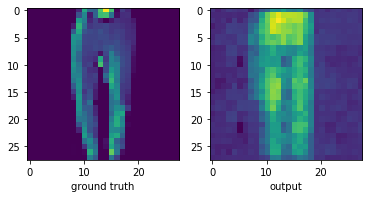

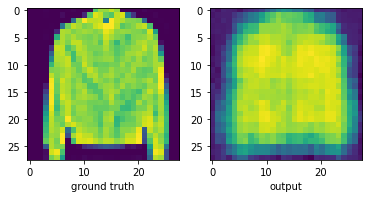

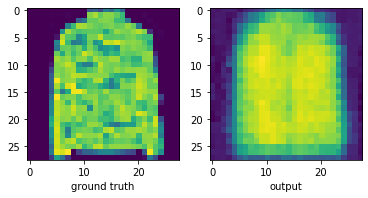

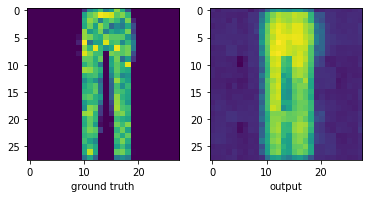

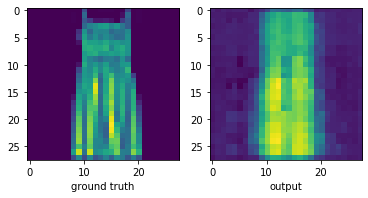

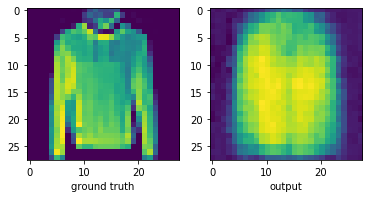

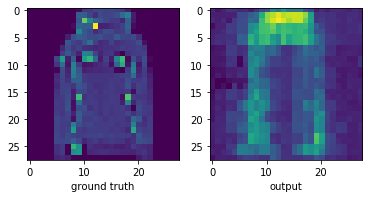

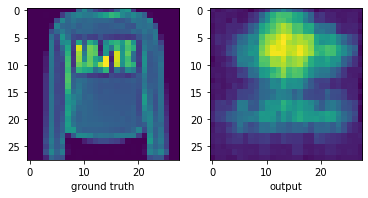

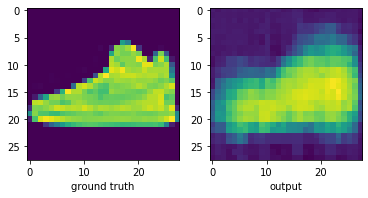

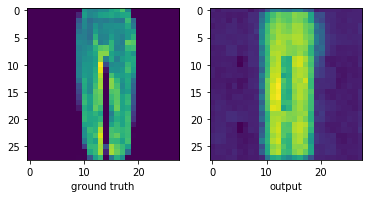

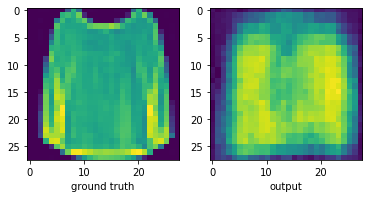

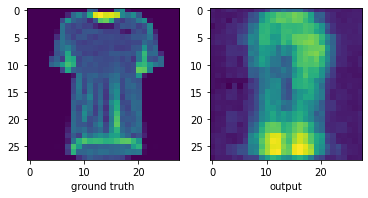

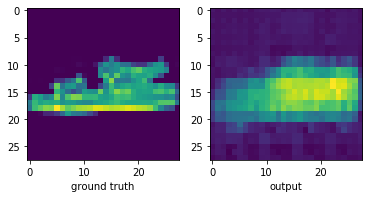

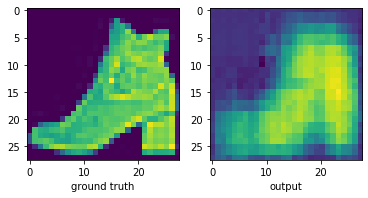

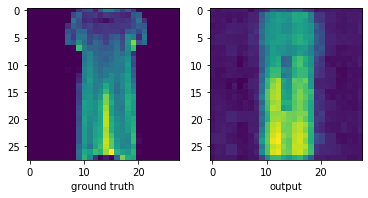

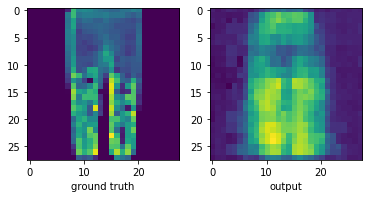

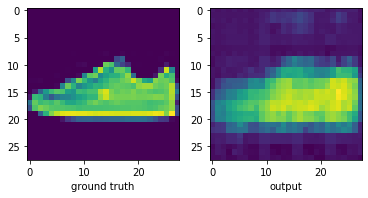

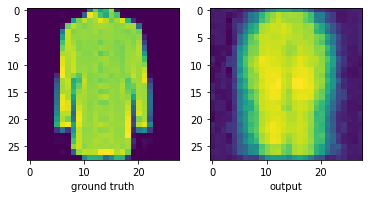

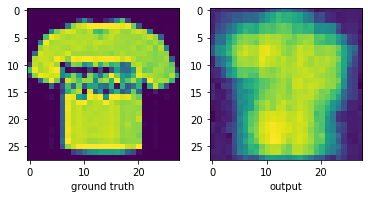

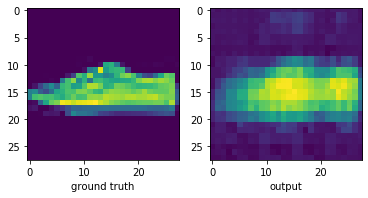

In [47]:
test(testloader,edNet,iterations)